# A note on preprocessing in Python

Preprocessing data does not occur in a vacuum. [Short description of preprocessing's relevance to data science & predicitve analytics]. Also, it is more important in some problems & technical frameworks than others. E.g. asking the question "How important is preprocessing in supervised learning tasks?" may not be the best approach because supervised learning is a large beast containing a plethora of modeling techniques, most easily subsettable into classification tasks and regression tasks. The former essentially invovles the prediction of categorical data, such as will someone surfing the web click on my advertisement or not, the later continuous data, such as housing price data. Certain types of preprocessing may be relevant to one and not the other. Herein, we'll explore the relevance of basic numerical preprocessing approaches to classification tasks. I'll also make sure that we put preprocessing in its most useful place, near the beginning of an iterative data science pipeline.

### A brief history of classification

[Insert history + examples here]
Classifying and labelling things in the phenomenal world is an ancient art. In the modern world, it is commonly framed as a machine learning task, in particular, a supervised learning task. The basic principle of supervised learning is straightforward: we have a bunch of data consisting of predictor variables and a target variable. The aim of **supervised learning** is to build a model that is 'good at' predicting the target variable, given the predictor variables. If the target variable consists of categories (e.g. 'click' or 'not', 'malignant' or 'benign' tumour), we call the learning task **classification**. Alternatively, if the target is a continuously varying variable (e.g. price of a house), it is a **regression** task. 

An illustrative example will go a long way here: consider the heart disease dataset (http://archive.ics.uci.edu/ml/datasets/Heart+Disease), in which there are 75 predictor variables, such as 'age', 'sex', 'smoker' or 'not' and the target variable refers to the presence of heart disease and ranges from 0 (no heart disease) to 4. Much work on this dataset has concentrated on attempts to distinguish the presence of heart disease from its absence. This is a classification task. If you were to attempt to predict the actual value (0 to 4) of the target variable, this would be a regression problem. We'll discuss regression in brief below. Here we'll look at one of the simplest algorithms for classification tasks, the K-nearest neighbours algorithm.

#### K-nearest neighbours

Let's say that we have some labeled data, for example, data that consists of characteristics of red wine (e.g. alcohol content, density, amount of citric acid, pH, etc...; these are the predictor variables) with target variable 'Quality' and labels 'good' & 'bad'. Then, given the characteristics of a new, unlabeled wine, the classification task is to predict its quality. When all the predictor variables are numerical (there are also ways to deal with the categorical case), we can consider each row/wine as a point in n-dimensional space and, in this case, k-nearest neighbours is a conceptually & computationally simple classification method: for each new, unlabeled wine, we calculate, for some integer k, its k nearest neighbours in the n-dimensional predictor variable space. Then we look at the labels of these k neighbours & assign the label with the most hits to the new wine (e.g. if k = 5, 3 neighbours vote 'good' and 2 vote 'bad', then our model labels the new wine 'good'). [Include a note on choosing k].

#### K-NN implementation (sklearn)

Let's check out the wine quality dataset (http://archive.ics.uci.edu/ml/datasets/Wine+Quality): we'll import it into a pandas dataframe and then plot histograms of the predictor variables:

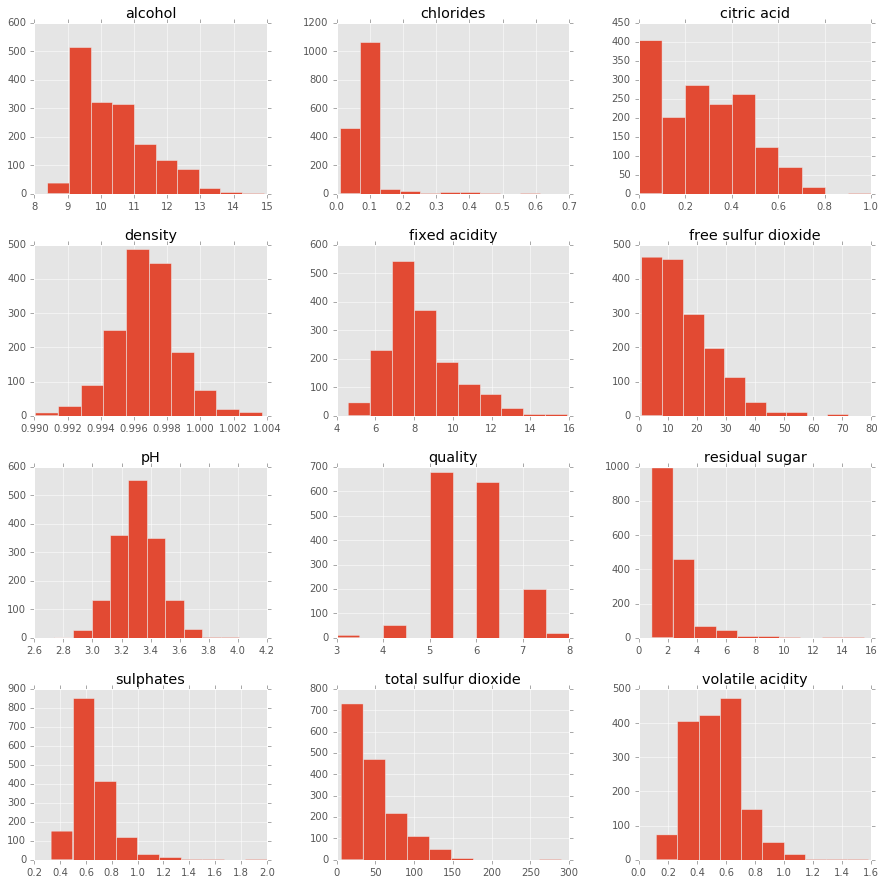

In [2]:
import pandas as pd
%matplotlib inline
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# from here: https://archive.ics.uci.edu/ml/datasets/Wine
df = pd.read_csv('wine_quality/winequality-red.csv' , sep = ';')
X = df.drop('quality' , 1).values #drop target variable
y1 = df['quality'].values
pd.DataFrame.hist(df, figsize = [15,15]);

The target variable is a rating and ranges from 3 to 8. For the purpose of expositional ease, let's turn it into a two-category variable consisting of 'good' (rating > 5) & 'bad' (rating <= 5). We'll also plot histograms of both formulations of the target variable to get a sense of what's going on.

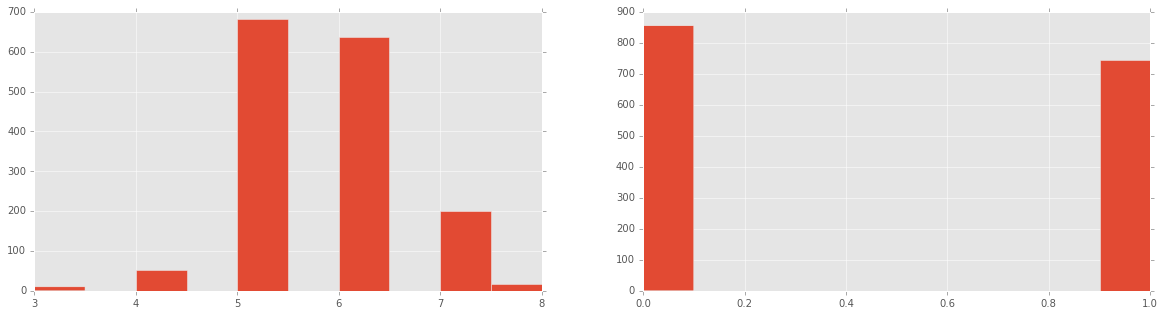

In [3]:
y = y1 <= 5
# y = [str(i) for i in y]
plt.figure(figsize=(20,5));
plt.subplot(1, 2, 1 );
plt.hist(y1);
plt.subplot(1, 2, 2);
plt.hist(y)
plt.show()

Now we're nearly ready to perform k-nearest neighbours. First off, though, if we're going to compare how our model performs with and without preprocessing, we'll need to figure out how to measure the 'goodness' of a model:

#### K-nearest neighbours: how well does it perform?

There are a number of performance measures for classification challenges. It is of the utmost importance to realise that the choice of performance measure is deeply domain & question specific [give some examples here]. In the case of a dataset with balanced classes, data scientists commonly look at *accuracy* as a performance measure. In fact, as we'll see, accuracy is the default scoring method for both K-nearest neighbours and logistic regression in scikit-learn. So what is accuracy? It is merely the number of correct predictions divided by the total number of data points:

$$\text{Accuracy}=\frac{\text{Number of Correct Predictions}}{\text{Total Number of Data Points}}.$$

*Note: accuracy can also be defined in terms of a confusion matrix; commonly defined for binary classification in terms of true positives & false negatives; give example of class imbalance in which accuracy is a poor measure (& what about Cohen's Kappa, then?)* **Also discuss, in brief, precision, recall and F1-score**.

#### K-nearest neighbours: performance in practice

It is all well and good to have a measure of performance such as accuracy (or whatever), but if we fit the model on all of the data we have, what dataset are we going we going to report the accuracy from. Remember that we want a model that generalises well to new data. Thus, if we train our model on a dataset D, reporting the accuracy of the model on the same data D may make it look as though it performs better than it actually does. This is precisely the concept of **overfitting** (see Appendix). To combat this issue, data scientists will commonly train their model on a subset of the data, called the **training set** and evaulate its performance on the rest of the data, the **test set**. This is precisely what we're going to do here! A general rule of thumb is to use approximately 80% of the data for training & 20% for test. Let's now split our data and plot both training and test sets to make sure that they're both representative of the dataset as a whole:

In [4]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We now build the model, make predictions on the test set and compare these predictions to the ground truth in order to get a measure of model performance:

In [5]:
from sklearn import neighbors, linear_model
knn = neighbors.KNeighborsClassifier(n_neighbors = 5)
knn_model_1 = knn.fit(X_train, y_train)
print('KNN score for test set: %f' % knn_model_1.score(X_test, y_test))
print('KNN score for training set: %f' % knn_model_1.score(X_train, y_train))

KNN score for test set: 0.612500
KNN score for training set: 0.774042


There are other measures that we could use:

In [6]:
from sklearn.metrics import classification_report
y_true, y_pred = y_test, knn_model_1.predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

      False       0.66      0.64      0.65       179
       True       0.56      0.57      0.57       141

avg / total       0.61      0.61      0.61       320



### The mechanics of preprocessing I: scaling and centering

Before running a model, such as regression (predicting a continuous variable) or clustering (predicing a discrete variable), on data, you almost always want to do some preprocessing. For numerical variables, it is common to either *normalize* or *standardize* your data. What do these terms mean?

All *normalization* means is scaling a dataset so that its minimum is 0 and its maximum 1. To achieve this we transform each data point $x$ to

$$x_{normalized} = \frac{x-x_{min}}{x_{max}-x_{min}}.$$

*Stardardization* is slightly different; it's job is to centre the data around 0 and to scale with respect to the standard deviation:

$$x_{standardized} = \frac{x-\mu}{\sigma},$$

where $\mu$ and $\sigma$ are the mean and standard deviation of the dataset, respectively. First note that these transformations merely change the range of the data and not the distribution. You may later wish to use any other nunmber of transforms, such as a log transform or a Box-Cox transform, to make your data look more Gaussian (like a bell-curve). But before we go further, it is important to ask the following questions: why do we scale our data? Are there times that it is more appropriate than others? For example, is it more important in classification problems than in regression? Or more important in clustering than in other classification methods?

Let's first delve into classification challenges and see how scaling your data affects clustering methods when compared with regression methods in classification problems:

EXPLAIN SOMEWHERE WHY IT WORKS. GIVE COUNTER-EXAMPLE OF MNIST DATASET?

#### Preprocessing numerical data: scaling

Now we do scale the data and, use k-nearest neighbours and check the model performance:

In [7]:
from sklearn.preprocessing import scale
# from sklearn.preprocessing import StandardScaler
Xs = scale(X)
from sklearn.cross_validation import train_test_split
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42)
knn_model_2 = knn.fit(Xs_train, y_train)
print('KNN score for test set: %f' % knn_model_2.score(Xs_test, y_test))
print('KNN score for training set: %f' % knn_model_2.score(Xs_train, y_train))
y_true, y_pred = y_test, knn_model_2.predict(Xs_test)
print(classification_report(y_true, y_pred))

KNN score for test set: 0.712500
KNN score for training set: 0.814699
             precision    recall  f1-score   support

      False       0.72      0.79      0.75       179
       True       0.70      0.62      0.65       141

avg / total       0.71      0.71      0.71       320



All these measures improved by 0.1, which is significant! Why? 

OK: lets now look at regression -- will scaling be as useful?

### A brief history of regression

#### Linear regression

As mentioned above, regression is commonly used to predict the value of one numerical variable from that of another. For example, below we perform a linear regression on Boston housing data: in this case, the independent variable (x-axis) is the number of rooms and the dependent variable (y-axis) is the price. 

How does such a regression work? In brief, the mechanics are as follows: we wish to fit a model $y = ax + b$ to the data $(x_i,y_i)$, that is, we want to find the optimal $a$ and $b$, given the data. In the ordinary least squares (OLS, by far the most common) formulation, there is an assumption that the error will occur in the dependent variable. For this reason, the optimal $a$ and $b$ are found by minimizing
$$SSE = \sum_i (y_i - (ax_i + b))^2$$
and this optimization is commonly achieved using an algorithm known as gradient descent. Here we perform a simple linear regression of the Boston housing data:

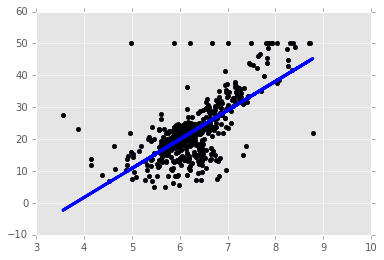

In [5]:
from sklearn import datasets
from sklearn import linear_model
import numpy as np
boston = datasets.load_boston()
y = boston.target.reshape(-1, 1)
X = boston['data'][:,5].reshape(-1, 1)
plt.scatter(X,y)
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit( X, y)
# Plot outputs
plt.scatter(X, y,  color='black')
plt.plot(X, regr.predict(X), color='blue',
         linewidth=3)
plt.show()

This regression captures the general trend of the data but not much more. We have used only one predictor variable and could have used many more, in which case we would have $n$ coefficients $a_1,\ldots,a_n$, one for eaxh predictor variable. It is worth noting that the magnitude of the variable $a_i$ tells us how strongly the corresponding variable is correlated with the target variable.

#### Logistic regression

[Insert history + examples here]. Then discuss regression being used for classification! 

#### Preprocessing for regression models:

Here we use a logistic regression classifier:

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn import neighbors, linear_model
lr = linear_model.LogisticRegression()
lr = lr.fit(X_train, y_train)
print('KNN score for test set: %f' % lr.score(X_test, y_test))
print('KNN score for training set: %f' % lr.score(X_train, y_train))
from sklearn.metrics import classification_report
y_true, y_pred = y_test, lr.predict(X_test)
print(classification_report(y_true, y_pred))

KNN score for test set: 0.740625
KNN score for training set: 0.752932
             precision    recall  f1-score   support

      False       0.78      0.74      0.76       179
       True       0.69      0.74      0.71       141

avg / total       0.74      0.74      0.74       320



Now with scaling:

In [114]:
Xs = scale(X)
from sklearn.cross_validation import train_test_split
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42)
lr_2 = lr.fit(Xs_train, y_train)
print('KNN score for test set: %f' % lr_2.score(Xs_test, y_test))
print('KNN score for training set: %f' % lr_2.score(Xs_train, y_train))
y_true, y_pred = y_test, lr_2.predict(Xs_test)
print(classification_report(y_true, y_pred))

KNN score for test set: 0.740625
KNN score for training set: 0.752150
             precision    recall  f1-score   support

      False       0.79      0.74      0.76       179
       True       0.69      0.74      0.72       141

avg / total       0.74      0.74      0.74       320



Why didn't performance improve with scaling? Explain this.

### CODA: in which all of these concepts and practices are elucidated, using a synthetic dataset:

The synthesized stuff here.

# What follows now are mainly notes:

## Preprocessing numerical data

As we have seen above, predictor variables can be either categorical or numerical. Here we'll explore the basic preprocessing steps of numerical data. There include
* Scaling and centering;
* Transformations;
* Identifying & dealing with correlated predictors, as well as those with linear dependencies;
* Imputation of missing values.

In upcoming articles, I'll look at (i) the preprocessing of categorical data and (ii) regularization techniques (which can also help deal with correlated predictors).



### The mechanics of preprocessing I: scaling and centering

Before running a model, such as regression (predicting a continuous variable) or clustering (predicing a discrete variable), on data, you almost always want to do some preprocessing. For numerical variables, it is common to either *normalize* or *standardize* your data. What do these terms mean?

All *normalization* means is scaling a dataset so that its minimum is 0 and its maximum 1. To achieve this we transform each data point $x$ to

$$x_{normalized} = \frac{x-x_{min}}{x_{max}-x_{min}}.$$

*Stardardization* is slightly different; it's job is to centre the data around 0 and to scale with respect to the standard deviation:

$$x_{standardized} = \frac{x-\mu}{\sigma},$$

where $\mu$ and $\sigma$ are the mean and standard deviation of the dataset, respectively. First note that these transformations merely change the range of the data and not the distribution. You may later wish to use any other nunmber of transforms, such as a log transform or a Box-Cox transform, to make your data look more Gaussian (like a bell-curve). But before we go further, it is important to ask the following questions: why do we scale our data? Are there times that it is more appropriate than others? For example, is it more important in classification problems than in regression? Or more important in clustering than in other classification methods?

Let's first delve into classification challenges and see how scaling your data affects clustering methods when compared with regression methods in classification problems:


## Preprocessing for Classification Challenges

[Let's check out some real-world datasets:]

#### KNN as classifier

[KNN for wine data: unprocessed, scaled & centered, log-transformed, box-cox?]

#### Logistic regression as classifier

[LogReg classifier for wine data: unprocessed, scaled & centered, log-transformed, box-cox?]

#### Why does this happen? lets now check out a synthesized dataset:

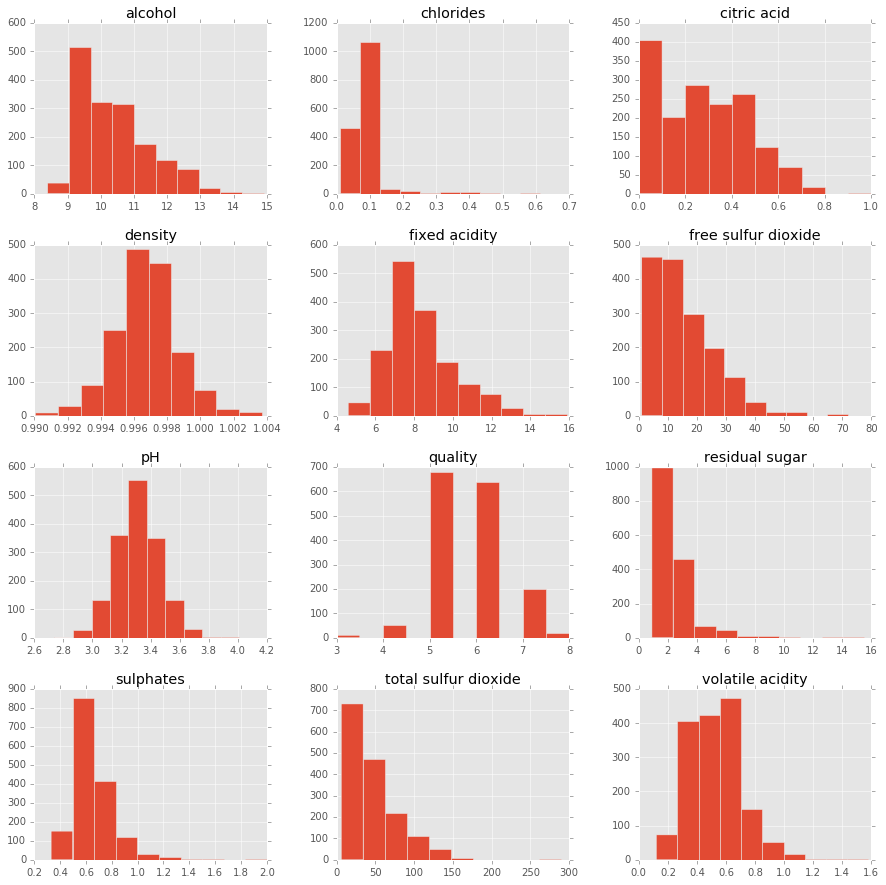

In [2]:
import pandas as pd
%matplotlib inline
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# from here: https://archive.ics.uci.edu/ml/datasets/Wine
df = pd.read_csv('wine_quality/winequality-red.csv' , sep = ';')
X = df.drop('quality' , 1).values #drop target variable
y1 = df['quality'].values
pd.DataFrame.hist(df, figsize = [15,15]);

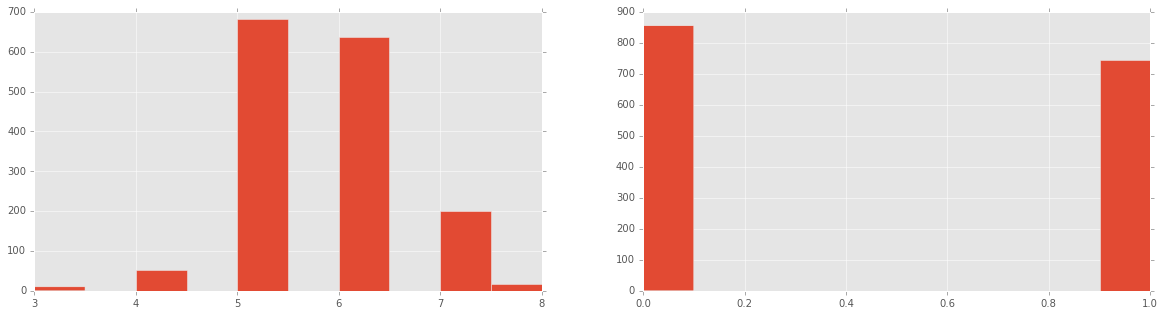

In [99]:
y = y1 <= 5
# y = [str(i) for i in y]
plt.figure(figsize=(20,5));
plt.subplot(1, 2, 1 );
plt.hist(y1);
plt.subplot(1, 2, 2);
plt.hist(y)
plt.show()

In [68]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
from sklearn import neighbors, linear_model
knn = neighbors.KNeighborsClassifier(n_neighbors = 5)
knn = linear_model.LogisticRegression()
knn_model_1 = knn.fit(X_train, y_train)
print('KNN score for test set: %f' % knn_model_1.score(X_test, y_test))
print('KNN score for training set: %f' % knn_model_1.score(X_train, y_train))

KNN score for test set: 0.740625
KNN score for training set: 0.752932


In [88]:
from sklearn.metrics import classification_report
y_true, y_pred = y_test, knn_model_1.predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

      False       0.78      0.74      0.76       179
       True       0.69      0.74      0.71       141

avg / total       0.74      0.74      0.74       320



In [89]:
from sklearn.preprocessing import scale
# from sklearn.preprocessing import StandardScaler
Xs = scale(X)
from sklearn.cross_validation import train_test_split
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42)
knn_model_2 = knn.fit(Xs_train, y_train)
print('KNN score for test set: %f' % knn_model_2.score(Xs_test, y_test))
print('KNN score for training set: %f' % knn_model_2.score(Xs_train, y_train))
y_true, y_pred = y_test, knn_model_2.predict(Xs_test)
print(classification_report(y_true, y_pred))

KNN score for test set: 0.740625
KNN score for training set: 0.752150
             precision    recall  f1-score   support

      False       0.79      0.74      0.76       179
       True       0.69      0.74      0.72       141

avg / total       0.74      0.74      0.74       320



In [90]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p)
X_l = transformer.transform(X)
Xns = scale(X_l)
Xns_train, Xns_test, y_train, y_test = train_test_split(Xns, y, test_size=0.2, random_state=42)
knn_model_3 = knn.fit(Xns_train, y_train)
print('KNN score for test set: %f' % knn_model_3.score(Xns_test, y_test))
print('KNN score for training set: %f' % knn_model_3.score(Xns_train, y_train))
y_true, y_pred = y_test, knn_model_3.predict(Xns_test)
print(classification_report(y_true, y_pred))

KNN score for test set: 0.737500
KNN score for training set: 0.750586
             precision    recall  f1-score   support

      False       0.78      0.73      0.76       179
       True       0.69      0.74      0.71       141

avg / total       0.74      0.74      0.74       320



In [91]:
from scipy import stats
Xt = np.zeros(np.shape(X))
for i in range(np.shape(Xt)[0]):
    Xt[i,:] = stats.boxcox(X[i,:] + 0.00005)[0]
Xns = scale(Xt)
Xns_train, Xns_test, y_train, y_test = train_test_split(Xns, y, test_size=0.2, random_state=42)
knn_model_3 = knn.fit(Xns_train, y_train)
print('KNN score for test set: %f' % knn_model_3.score(Xns_test, y_test))
print('KNN score for training set: %f' % knn_model_3.score(Xns_train, y_train))
y_true, y_pred = y_test, knn_model_3.predict(Xns_test)
print(classification_report(y_true, y_pred))

KNN score for test set: 0.731250
KNN score for training set: 0.731040
             precision    recall  f1-score   support

      False       0.77      0.74      0.76       179
       True       0.69      0.72      0.70       141

avg / total       0.73      0.73      0.73       320



## Preprocessing for Classification Challenges

In order to see how data scaling affects classification challenges, we'll first synthesize a dataset. This is a good approach so that we know exactly what is going on in it. In the code chunk below, we use scikit-learn's make_blobs function to generate 2000 data points that are in 4 clusters (each data point has 2 predictor variables and 1 target variable):

In [1]:
# Generate some clusteres data (blobs!)
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
n_samples=2000
X, y = make_blobs(n_samples, centers=4, n_features=2,
                  random_state=0)
print('The shape of X is %s.' % str(X.shape))
print('The shape of y is %s.' % str(y.shape))

The shape of X is (2000, 2).
The shape of y is (2000,).


#### Plotting the synthesized data

We'll now plot in the plane the data that we've synthesized. Each axis is a predictor variable and the colour is a key to the target variable:

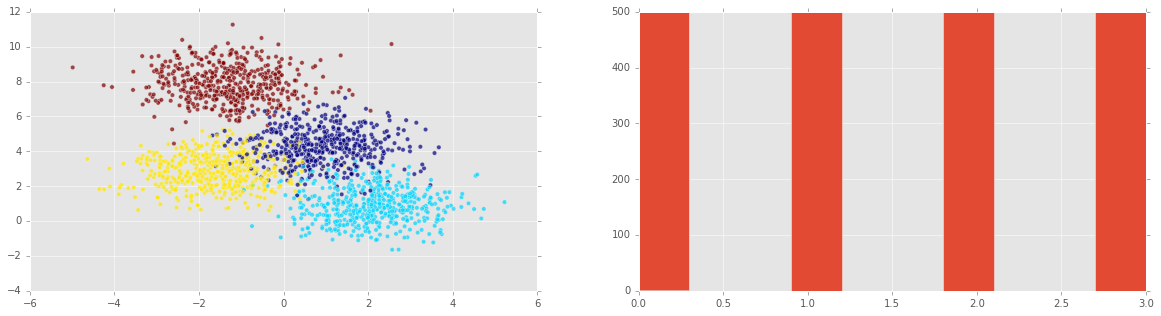

In [2]:
%matplotlib inline
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
plt.style.use('ggplot') # Make the graphs a bit prettier
plt.figure(figsize=(20,5));
plt.subplot(1, 2, 1 );
plt.scatter(X[:,0] , X[:,1],  c = y, alpha = 0.7);
plt.subplot(1, 2, 2);
plt.hist(y)
plt.show()
#label axes

*Note: we can see in the 2nd plot that all possible target variables are equally represented. In this case (or even if they are approximately equally represented), we say that the class y is balanced.*

I now want to plot histograms of the features (predictor variables). The easiest way to do this (that I know of) is converting numpy array to a pandas dataframe and calling pd.DataFrame.hist():

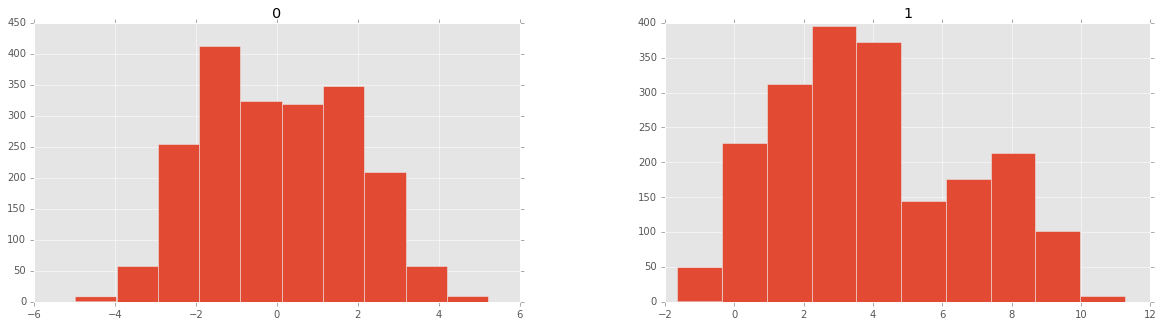

In [3]:
import pandas as pd
df = pd.DataFrame(X)
pd.DataFrame.hist(df, figsize=(20,5));

#### Essential philosophy and practice: preprocessing as an element of the pipeline

Preprocessing does not occur in a vacuum. This to say that we don't preprocess for preprocessing's sake, but we do it in order to improve how well our models work, that is, their predictive power. Here we will delve into how scaling our data affects (i) clustering algorithms for classification (in the form of k-nearest neighbours) & (ii) regression algorithms for classification (in the form of logistic regression).

We can reformulate this question as follows: does k-nearest neighbours perform better as a classifier when we scale the data, or when we don't, and similarly for logistic regression?

To answer the reformulated question, we realise that we need to know a bit more about these models and how we can gauge how good they are. That is, we need to define performance measures for the models. Let's do that now:

#### K-nearest neighbours: how it works

[Insert here description of K nearest neighbours]

#### K-nearest neighbours: how well does it perform?

There are a number of performance measures for classification challenges. It is of the utmost importance to realise that the choice of performance measure is deeply domain & question specific [give some examples here]. In the case of a dataset with balanced classes, data scientists commonly look at *accuracy* as a performance measure. In fact, as we'll see, accuracy is the default scoring method for both K-nearest neighbours and logistic regression in scikit-learn. So what is accuracy? It is merely the number of correct predictions divided by the total number of data points:

$$\text{Accuracy}=\frac{\text{Number of Correct Predictions}}{\text{Total Number of Data Points}}.$$

*Note: accuracy can also be defined in terms of a confusion matrix; commonly defined for binary classification in terms of true positives & false negatives; give example of class imbalance in which accuracy is a poor measure (& what about Cohen's Kappa, then?)*

#### K-nearest neighbours: performance in practice

It is all well and good to have a measure of performance such as accuracy (or whatever), but if we fit the model on all of the data we have, what dataset are we going we going to report the accuracy from. Remember that we want a model that generalises well to new data. Thus, if we train our model on a dataset D, reporting the accuracy of the model on D may make it look as though it performs better than it actually does. This is precisely the concept of **overfitting** (see Appendix). To combat this issue, data scientists will commonly train their model on a subset of the data, called the **training set** and evaulate it's performance on the rest of the data, the **test set**. This is precisely what we're going to do here! A general rule of thumb is to use approximately 80% of the data for training & 20% for test. Let's now split our data and plot both training and test sets to make sure that they're both representative of the dataset as a whole:

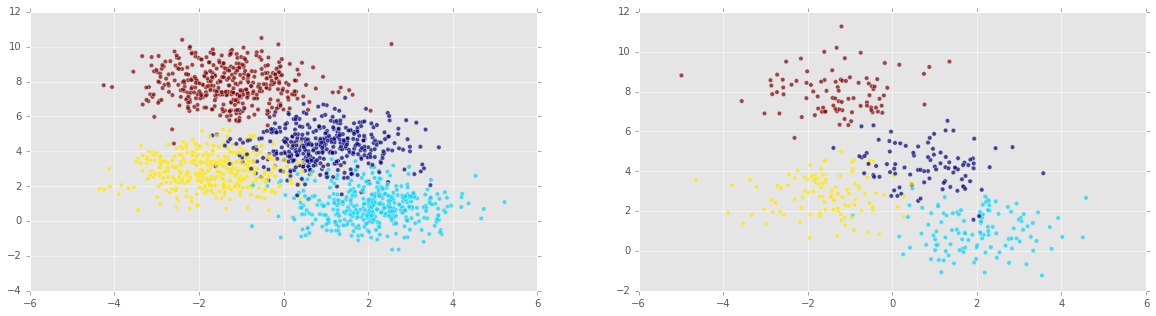

In [4]:
s = int(.8*n_samples)
X_train = X[:s]
y_train = y[:s]
X_test = X[s:]
y_test = y[s:]
plt.figure(figsize=(20,5));
plt.subplot(1, 2, 1 );
plt.scatter(X_train[:,0] , X_train[:,1],  c = y_train, alpha = 0.7);
plt.subplot(1, 2, 2);
plt.scatter(X_test[:,0] , X_test[:,1],  c = y_test, alpha = 0.7);
plt.show()

Looking good! Now let's instantiate a k-nearest neighbors voting classifier and train it on our training set:

In [5]:
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier()
knn_model = knn.fit(X_train, y_train)

Now that we have trained our model we can fit it to our test set and compute the accuracy:

In [6]:
print('KNN score for test set: %f' % knn_model.score(X_test, y_test))

KNN score for test set: 0.930000


We can also re-fit it to our training set and compute the accuracy. We would expect it to perform better on the training set than the test set:

In [7]:
print('KNN score for training set: %f' % knn_model.score(X_train, y_train))

KNN score for training set: 0.943750


#### Now with scaling

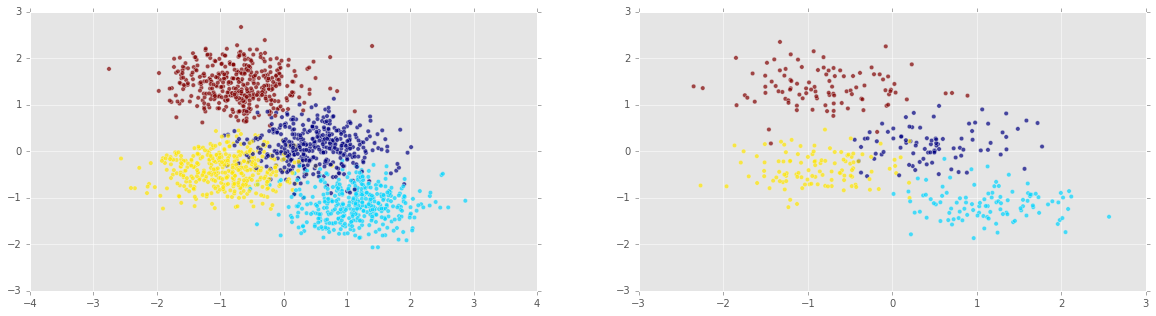

In [8]:
from sklearn.preprocessing import scale
# from sklearn.preprocessing import StandardScaler
Xs = scale(X)
s = int(.2*n_samples)
Xs_train = Xs[s:]
y_train = y[s:]
Xs_test = Xs[:s]
y_test = y[:s]
plt.figure(figsize=(20,5));
plt.subplot(1, 2, 1 );
plt.scatter(Xs_train[:,0] , Xs_train[:,1],  c = y_train, alpha = 0.7);
plt.subplot(1, 2, 2);
plt.scatter(Xs_test[:,0] , Xs_test[:,1],  c = y_test, alpha = 0.7);
plt.show()

In [35]:
knn_model_s = knn.fit(Xs_train, y_train)
print('KNN score for test set: %f' % knn_model_s.score(Xs_test, y_test))

KNN score for test set: 0.930000


It doesn't perform any better. Probably because both features were already around the same range. It really makes sense to scale when variables have widely varying ranges. To see this in action, we're going to add another feature. Moreover, this feature will bear no relevance to the target variable: it will be mere noise.

#### Adding noise to the signal:

We add a third variable of Gaussian noise with mean 0 and variable standard deviation $\sigma$. We'll call $\sigma$ the strength of the noise and we'll see that the stronger the noise, the worse the performance of k-nearest neighbours.

In [9]:
# Add noise column to predictor variables
ns = 10**(3) # Strength of noise term
newcol = np.transpose([ns*np.random.randn(n_samples)])
Xn = np.concatenate((X, newcol), axis = 1)
print('The shape of the new feature array is %s.' % str(Xn.shape))

The shape of the new feature array is (2000, 3).


We'll now use the mplot3d package to plot the 3D data:

(-10000, 10000)

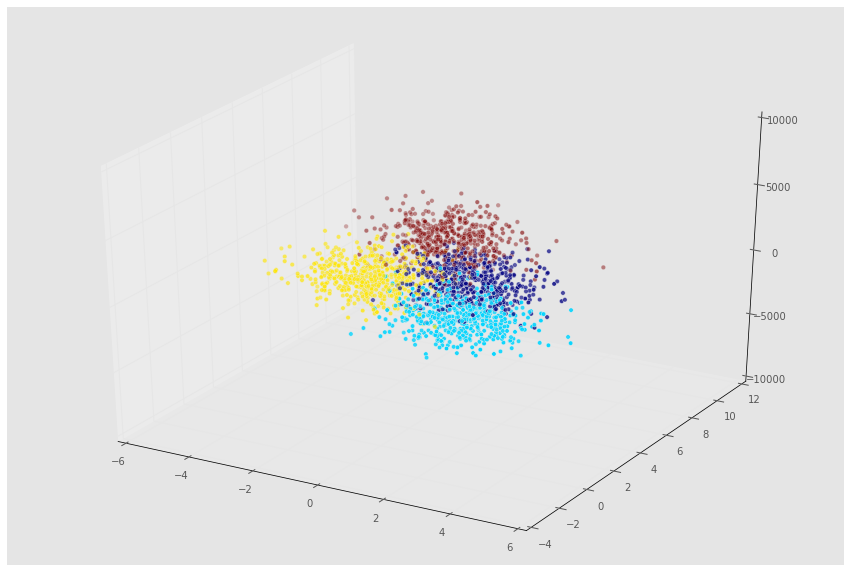

In [10]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,10));
ax = fig.add_subplot(111, projection='3d' , alpha = 0.5);
ax.scatter(Xn[:,0], Xn[:,1], Xn[:,2], c = y);
# ax.set_xlabel('1st PC')
# ax.set_ylabel('2nd PC')
# ax.set_zlabel('3rd PC')
ax.set_zlim((-10*ns,10*ns))

Now let's see how our model performs on the new data:

In [11]:
s = int(.2*n_samples)
Xn_train = Xn[s:]
y_train = y[s:]
Xn_test = Xn[:s]
y_test = y[:s]
knn = neighbors.KNeighborsClassifier()
knn_model = knn.fit(Xn_train, y_train)
print('KNN score for test set: %f' % knn_model.score(Xn_test, y_test))

KNN score for test set: 0.337500


Horrible! How about we scale and check out performance?

In [22]:
Xns = scale(Xn)
s = int(.2*n_samples)
Xns_train = Xns[s:]
y_train = y[s:]
Xns_test = Xns[:s]
y_test = y[:s]
knn = neighbors.KNeighborsClassifier()
knn_models = knn.fit(Xns_train, y_train)
print('KNN score for test set: %f' % knn_models.score(Xns_test, y_test))

KNN score for test set: 0.915000


Whoa! Great: [some further words here].

#### The stronger the noise, the bigger the problem:

We're now going to see how the noise strength effects model accuracy. As we'll need to use the same code a number of times, let's actually wrap up the main parts in a small function:

In [23]:
def accu( X, y):
    s = int(.8*n_samples)
    X_train = X[:s]
    y_train = y[:s]
    X_test = X[s:]
    y_test = y[s:]
    knn = neighbors.KNeighborsClassifier()
    knn_model = knn.fit(X_train, y_train)
    return(knn_model.score(X_test, y_test))

In [36]:
ns = 10**(-3) # Strength of noise term
newcol = np.transpose([ns*np.random.randn(n_samples)])
Xn = np.concatenate((X, newcol), axis = 1)
Xns = scale(Xn)
print(accu( Xn, y))
print(accu( Xns, y))

0.93
0.9275


In [53]:
noise = [10**i for i in np.arange(-1,6)]
A1 = np.zeros(len(noise))
A2 = np.zeros(len(noise))
count = 0
for ns in noise:
    newcol = np.transpose([ns*np.random.randn(n_samples)])
    Xn = np.concatenate((X, newcol), axis = 1)
    Xns = scale(Xn)
    A1[count] = accu( Xn, y)
    A2[count] = accu( Xns, y)
    count += 1

We now plot accuracy as a function of noise strength (note log x axis):

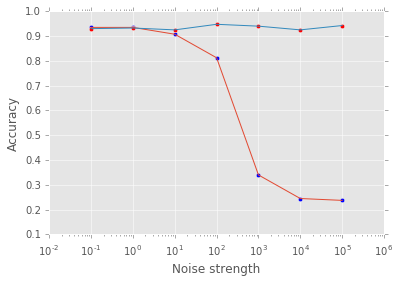

In [73]:
plt.scatter( noise, A1)
plt.plot( noise, A1)
plt.scatter( noise, A2 , c = 'r')
plt.plot( noise, A2)
plt.xscale('log')
plt.xlabel('Noise strength')
plt.ylabel('Accuracy')
plt.show()

## Now let's check out scaling on some real datasets (maybe include this at the start!)

#### Wine data

In [81]:
# from here: https://archive.ics.uci.edu/ml/datasets/Wine
df = pd.read_csv('wine_quality/winequality-red.csv' , sep = ';')
X = df.drop('quality' , 1).values #drop target variable
y = df['quality'].values
A = accu(X,y) #accuracy
A_s = accu(scale(X),y) #accuracy after scaling features (predictor variables)
print(A)
print(A_s)

0.444444444444
0.524691358025


try out a log transform also:

In [87]:
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p)
X_l = transformer.transform(X)
A_l = accu(scale(X_l),y) #accuracy after scaling features (predictor variables)
print(A_l)

0.549382716049


#### MNIST data

In [70]:
# http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
from sklearn.datasets import load_digits
digits = load_digits()
# data = scale(digits.data)
X = digits.data
y = digits.target

In [71]:
n_samples = np.shape(X)[0]
s = int(.8*n_samples)
X_train = X[:s]
y_train = y[:s]
X_test = X[s:]
y_test = y[s:]
knn = neighbors.KNeighborsClassifier()
knn_model = knn.fit(X_train, y_train)
print('KNN score for test set: %f' % knn_model.score(X_test, y_test))

KNN score for test set: 0.963889


In [72]:
Xs = scale(X)
s = int(.8*n_samples)
Xs_train = Xs[:s]
y_train = y[:s]
Xs_test = Xs[s:]
y_test = y[s:]
knn_model_s = knn.fit(Xs_train, y_train)
print('KNN score for test set: %f' % knn_model_s.score(Xs_test, y_test))

KNN score for test set: 0.938889


After scaling, it actually performed worse! Now I understand why it wouldn't necessarily perform better; perhaps because all pixels had approximately the same scale, from 0 to 16, before scaling. It may perform worse because it could strengthen those features with near-zero variance. This is worth exploring further.